# Comparison of thin plate spline and its Laplacian approximation in 2D

This notebook reproduces figures from the paper

In [1]:
using Laplacians, LinearAlgebra, SparseArrays, LaplaceInterpolation
using TestImages, Colors, FileIO, JLD, BenchmarkTools
using Plots, ThinPlateSplines

In [2]:
# include("ThinPlateSplines.jl")

## Mandrill 2D Example

Here we load in the mandrill test image and discard roughly 75% of the data.

There are 129540 interior nodes, and 1534 boundary nodes.
We discard 0.762939453125 percent of the data.


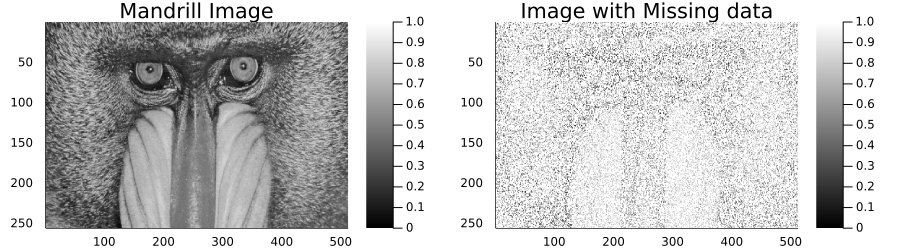

In [11]:
# Example from TestImages package
img = testimage("mandrill")

# Flatten the image to grayscale and select a subset of the image
imgg = Gray.(img)
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]

# return_boundary_nodes
#=
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
print(size(NonBoundaryNodes))
=#
println("There are $((rows - 2) * (columns - 2)) interior nodes, and $(2 * rows + 2 * columns - 2) boundary nodes.")

No_of_nodes_discarded = 100000

println("We discard $(100.0 * No_of_nodes_discarded / N) percent of the data.")

discard = randperm(N)[1:No_of_nodes_discarded]
# We can discard nodes on the boundary now
#=
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];
=#

holeyimage1 = copy(mat)
holeyimage1[discard] .= 1

p1 = heatmap(mat, title = "Mandrill Image", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p2 = heatmap(holeyimage1, title = "Image with Missing data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))

plot(p1, p2, layout = (1,2), size = (900, 250))

# Reconstruction using Matern and Laplace interpolations

In [14]:
#=
function Matern2D_Grid(mat, epsilon, m)
    rows, columns = size(mat)
    A2D = ∇²2d_Grid(rows, columns, 1, 1)
    C = sparse(I, rows * columns, rows * columns)
    for i in discard
        C[i,i] = 0
    end
    Id = sparse(I, rows * columns, rows * columns)
    f = mat[:]
    if (m == 1)||(m == 1.0)
        # Laplace interpolation
        u = ((C - (Id - C) * A2D)) \ (C*f)
        return reshape(u, rows, columns)
    else
        sizeA = size(A2D, 1)
        for i = 1:sizeA
            A2D[i,i] = A2D[i,i] + epsilon^2
        end
        A2D = A2D^m
        u = ((C - (Id - C) * A2D)) \ (C * f)
        restored_img_matern = reshape(u, rows, columns)   
        return restored_img_matern
    end
end
=#

restored_img_laplace = Matern2D_Grid(mat, 0.0, 1)
restored_img_matern = Matern2D_Grid(mat, 0.0, 2)

#=
A2D = ∇²2d_Grid(rows, columns, 1, 1)
C = sparse(I, rows*columns, rows*columns)
for i in discard
    C[i,i] = 0;
end
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A2D)) \ (C*f);
restored_img_laplace = reshape(u, size(mat,1), size(mat,2));
A = ∇²2d_Grid(rows, columns, 1, 1);
epsilon = 0.0
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end
A2DM = A*A;
u =((C-(Id -C)*A2DM)) \ (C*f);
restored_img_matern = reshape(u, size(mat,1), size(mat,2));
=#


256×512 Array{Float64,2}:
 0.189866  0.163547  0.166765  0.252671  …  0.560931  0.6       0.591903
 0.230382  0.180862  0.156863  0.262745     0.471971  0.481151  0.489278
 0.301961  0.22623   0.180392  0.271349     0.356836  0.345098  0.37174
 0.326131  0.264284  0.224248  0.25367      0.286275  0.294614  0.324508
 0.341176  0.28329   0.257763  0.232176     0.231373  0.285602  0.337255
 0.321569  0.270268  0.329329  0.239216  …  0.265903  0.337257  0.385215
 0.170174  0.2       0.52549   0.484544     0.443664  0.462619  0.483056
 0.129412  0.253864  0.517309  0.6          0.598575  0.571216  0.573223
 0.148861  0.263369  0.437871  0.506317     0.571388  0.571201  0.594433
 0.148231  0.238962  0.356657  0.403381     0.435195  0.470176  0.533333
 0.129412  0.210689  0.306399  0.340034  …  0.254902  0.306972  0.367327
 0.129412  0.201773  0.303172  0.328156     0.204856  0.219396  0.251642
 0.112804  0.190819  0.343324  0.354879     0.201474  0.201683  0.22225
 ⋮                         

# Reconstruction Errors

In [11]:
error_laplace = abs.(restored_img_laplace - mat);
error_matern = abs.(restored_img_matern - mat);

# Plotting and Saving

In [12]:
plot1 = Plots.plot(Gray.(mat), title="Original Data", pointsize=15);
plot2 = Plots.plot(Gray.(holeyimage1), title="Data with missing points");
plot3 = Plots.plot(Gray.(restored_img_laplace), title="Laplace Interpolated Image");
plot4 = Plots.plot(Gray.(restored_img_matern), title="Matern, m = 2, eps = 0.0");
Plots.plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false)
png("Mandrill_Random.png")

In [ ]:
plot1 = heatmap(error_laplace, c= :balance, title="Laplace Error", pointsize=15);
plot2 = heatmap(error_matern, c= :balance, title="Matern Error", pointsize=15);
Plots.plot(plot1, plot2, layout = (1, 2), legend = false)
png("Mandrill_Random_Errors.png")

In [ ]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;

In [ ]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
Plots.plot(Gray.(holeyimage))

In [ ]:
 # if you need
using PyPlot

include("polyharmonic_splines.jl") 
# contain all code from https://github.com/lstagner/OrbitTomography.jl/blob/master/src/polyharmonic.jl
# and `interpolate()`definition from https://gist.github.com/lstagner/04a05b120e0be7de9915

# x = floor.(keep/(size(mat,1)));
# y = (keep.%(size(mat,1)));
# z = holeyimage[S[keep]];
# S2 = PolyharmonicSpline(2,[x y],z)

# BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1000;
# BenchmarkTools.DEFAULT_PARAMETERS.samples = 50;

function tps_interpolate()
xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 80:120
    for y in 180:220
        if((x -100)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 380:420
    for y in 180:220
        if((x -400)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 180:220
    for y in 80:120
        if((x -200)^2 + (y-100)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end
S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

x=ones(41)*(80:120)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
holeyimage_copy = copy(holeyimage)
count =1;
for i in 80:120
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(180:220)';
xx = reshape(x,41*41);
y = (80:120)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 180:220
    for j in 80:120
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(380:420)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 380:420
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end
return holeyimage_copy
end
    

#@btime tps_interpolate()
holeyimage_copy = tps_interpolate()




# xgrid = ones(K)*1:size(mat,1)'
# ygrid = 1:size(mat,2)*ones(L)'

# xx = reshape(xgrid,L*K)
# yy = reshape(ygrid,L*K)

# zz = interpolate(S2,xx,yy)
# zgrid = reshape(zz,n,n);

# plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
# scatter3D(x,y,z,color="r")
# show()




In [ ]:
#@benchmark begin
include("../Matern1D2D.jl")
holeyimage_copy_m = copy(holeyimage);
restored_img1, punched_img = Matern2D(41, 41, mat[80:120,180:220], 0, [(21,21)], 20.0);
count =1;

holeyimage_copy_m[80:120,180:220] = restored_img1;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,80:120], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,80:120] = restored_img;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,380:420], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,380:420] = restored_img;

#end

## Comparison of errors between TPS and Matern Interpolation

In [ ]:
Error_TPS = abs.(mat - holeyimage_copy)
Error_Matern = abs.(mat - holeyimage_copy_m)
plot1 = heatmap(Error_TPS, c= :balance, title="Error in TPS interpolation");
plot2 = heatmap(Error_Matern, c= :balance, title="Error in Matern interpolation");
Plots.plot(plot1, plot2, layout = (1, 2), legend = false)
png("Mandrill_Errors.png")

In [ ]:
ENV["MPLBACKEND"]="tkagg" # if you need

x,y = randn(500),randn(500)
z = exp.(-(x.^2 .+ y.^2))
S2 = PolyharmonicSpline(2,[x y],z)

n=20
xgrid = ones(n)*range(-3,stop=3,length=n)'
ygrid = range(-3,stop=3,length=n)*ones(n)'

xx = reshape(xgrid,n*n)
yy = reshape(ygrid,n*n)

zz = interpolate(S2,xx,yy)
zgrid = reshape(zz,n,n);

plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
scatter3D(x,y,z,color="r")
show()

Take the laplacian matrix and plot it as a heatmap
Implement Dirichlet, Neumann, and Periodic BCs.

In [ ]:

L = 1:300
K = 1:300
xmax = 300
ymax = 300
length_array = length(L)*length(K)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
stdx = 50
stdy = 50
mux = 150
muy = 150
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")


In [ ]:
function evaluate_rbfkernel(r)
    if(r <= 1e-13)
        return 0
    else
        return r*r*log(r)*0.217147241
    end
end

In [ ]:
fvalues = zeros(length_array)
count =1

for i = 1:ymax
    for j = 1:xmax
        xcoor = j-1
        ycoor = i-1
        for k = 1:number_of_control_points
            r = sqrt((xcoordinate[k] - xcoor)^2 +  (ycoordinate[k] - ycoor)^2)
            fvalues[count] = fvalues[count] + weights[k]*evaluate_rbfkernel(r/100)
        end
        count = count+1
    end
end
        

In [ ]:
n=300
xgrid = ones(n)*range(1,stop=300,length=n)'
ygrid = range(1,stop=300,length=n)*ones(n)'
fvalues_mat = reshape(fvalues, xmax, ymax)
plot_surface(xgrid,ygrid,fvalues_mat,alpha=0.5)

In [ ]:
heatmap(fvalues_mat, c= :balance)

In [ ]:
include("../Matern1D2D.jl")
restored_img1, punched_img = Matern2D(300, 300, fvalues_mat[1:300,1:300], 0, [(100,100)], 50);

In [ ]:
heatmap(restored_img1, c=:balance)

In [ ]:
plot1 = heatmap(fvalues_mat, c= :balance, title="RBF Kernel Data", pointsize=15);
plot2 = heatmap(punched_img, c= :balance, title="Data with missing points");
plot3 = heatmap(restored_img1, c= :balance, title="Matern Interpolated Image");
plot4 = heatmap(abs.(restored_img1 - fvalues_mat), c= :balance, title="Error in Mat Interp");
Plots.plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false)
png("RBF_Errors_Matern.png")

# Verifying PolyharmonicSpline code

In [ ]:
include("ThinPlateSplines.jl")
include("polyharmonic_splines.jl") 

xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 1:xmax
    for y in 1:ymax
        if((x -100)^2 + (y-100)^2 > 50^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, fvalues_mat[y,x]);
        end
    end
end

S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

zz = interpolate(S2,xgrid,ygrid)
zz_reshape = reshape(zz, xmax,ymax)

# 3D Example

In [ ]:
function evaluate_rbfkernel3D(r)
    return r
end

In [ ]:
using PyPlot
L = 1:50
K = 1:50
H = 1:50
length_array = length(L)*length(K)*length(H)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
zcoordinate = zeros(number_of_control_points)

stdx = 8
stdy = 8
mux = 25
muy = 25
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")